In [2]:
import sys, platform
print("Python:", sys.version)
print("OS:", platform.platform())
try:
    import tensorflow as tf
    print("tensorflow:", tf.__version__, "| GPUs:", len(tf.config.list_physical_devices('GPU')))
except Exception as e:
    print("TF-Check:", e)


Python: 3.10.11 (tags/v3.10.11:7d4cc5a, Apr  5 2023, 00:38:17) [MSC v.1929 64 bit (AMD64)]
OS: Windows-10-10.0.26100-SP0
tensorflow: 2.20.0 | GPUs: 0


In [3]:
import os
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import numpy as np

In [4]:
TICKER   = "AAPL"           # Beispiel: Apple
START    = "2012-01-01"
END      = "2025-09-01"
INTERVAL = "1d"
HORIZON = 1                 # Vorhersage: 1 Tag in die Zukunft

In [5]:
df = yf.download(TICKER, start=START, end=END, interval=INTERVAL, auto_adjust=True)

[*********************100%***********************]  1 of 1 completed


In [6]:
df = df.rename(columns={
    "Open": "open",
    "High": "high",
    "Low": "low",
    "Close": "close",
    "Volume": "volume"
}).dropna()

if isinstance(df.columns, pd.MultiIndex):
    df.columns = df.columns.get_level_values(-1)

df.columns.name = None
df.index.name = "date"


In [7]:
# ---- Erste Kontrolle ----
print("Erste Zeilen:\n", df.head(3), "\n")
print("Letzte Zeilen:\n", df.tail(3), "\n")
print("Zeitraum:", df.index.min().date(), "→", df.index.max().date(), "| Anzahl Zeilen:", len(df))

Erste Zeilen:
 Price           close       high        low       open     volume
Ticker           AAPL       AAPL       AAPL       AAPL       AAPL
Date                                                             
2012-01-03  12.345171  12.383297  12.278227  12.290235  302220800
2012-01-04  12.411520  12.448746  12.286637  12.308251  260022000
2012-01-05  12.549309  12.564919  12.388400  12.456847  271269600 

Letzte Zeilen:
 Price            close        high         low        open    volume
Ticker            AAPL        AAPL        AAPL        AAPL      AAPL
Date                                                                
2025-08-27  230.490005  230.899994  228.259995  228.610001  31259500
2025-08-28  232.559998  233.410004  229.339996  230.820007  38074700
2025-08-29  232.139999  233.380005  231.369995  232.509995  39418400 

Zeitraum: 2012-01-03 → 2025-08-29 | Anzahl Zeilen: 3435


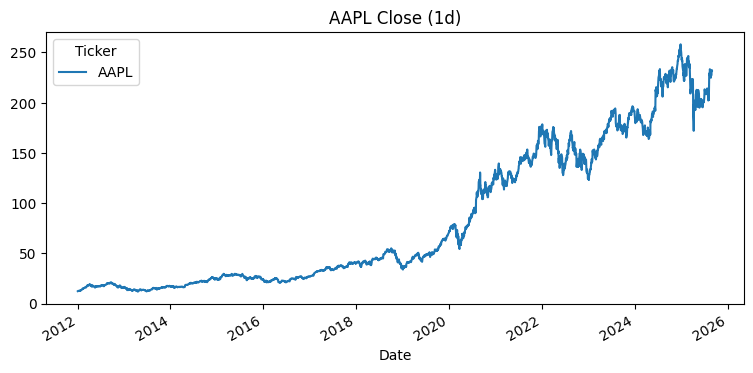

In [8]:
# ---- Plausibilitätscheck: Plot ----
# Wir plotten den Schlusskurs (close), um einen groben Überblick zu bekommen.
df["close"].plot(title=f"{TICKER} Close ({INTERVAL})", figsize=(9,4))
plt.show()

In [9]:
# ---- CSV "einfrieren" ----
# Speicherung im Ordner ../data (eine Ebene über notebooks/)
# Vorteil: Reproduzierbarkeit – ab jetzt nutzen wir immer diesen Schnappschuss.
os.makedirs("../data", exist_ok=True)
csv_path = f"../data/{TICKER}_{INTERVAL}_{START}_{END}.csv"
df.to_csv(csv_path)

print("CSV gespeichert unter:", csv_path)

CSV gespeichert unter: ../data/AAPL_1d_2012-01-01_2025-09-01.csv


In [17]:
# Pfad zum CSV aus Block 1
csv_in  = f"../data/{TICKER}_{INTERVAL}_{START}_{END}.csv"
assert os.path.exists(csv_in), f"CSV nicht gefunden: {csv_in}"

# ---- 1) CSV ROBUST EINLESEN ----
def read_prices(csv_path: str) -> pd.DataFrame:
    import pandas as pd

    df = pd.read_csv(csv_path, index_col=0, parse_dates=[0])
    df.index = pd.to_datetime(df.index, format="%Y-%m-%d", errors="coerce")
    df = df[~df.index.isna()]
    df = df.sort_index()

    if df.index.has_duplicates:
        raise ValueError("Duplicate timestamps found in price data")

    df.columns = [str(c).lower() for c in df.columns]
    df.columns.name = None
    df.index.name = "date"

    keep = ["open", "high", "low", "close", "volume"]
    df = df[[c for c in df.columns if c in keep]].copy()

    for c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce")

    df = df.dropna(how="any")

    return df

df = read_prices(csv_in)


In [18]:
# ---- 2) Hilfsfeature: 1-Tages-Logreturn (optional) ----
na_counts = df.isna().sum()
assert na_counts.sum() == 0, f"Remaining NaNs detected: {na_counts[na_counts > 0]}"

if (df["close"] <= 0).any():
    raise ValueError("Close prices must be positive for log-return computation")

df["logret_1d"] = np.log(df["close"]).diff()

# ---- 3) Zielvariable: Up/Down in HORIZON Schritten ----
future_log = np.log(df["close"]).shift(-HORIZON)
curr_log   = np.log(df["close"])
y_return   = future_log - curr_log
df["target"] = (y_return > 0).astype(int)


In [19]:
# Aufräumen (erste diff-Zeile & letzte HORIZON-Zeilen)
df_clean = df.dropna().copy()

In [20]:
# ---- 4) Checks ----
print("Spalten:", df_clean.columns.tolist())
print("Zeitraum:", df_clean.index.min().date(), "→", df_clean.index.max().date(), "| n =", len(df_clean))

print("\nVorschau:\n", df_clean[["close","logret_1d","target"]].head())

vc = df_clean["target"].value_counts().sort_index()
print("\nKlassenverteilung 0/1:", vc.to_dict(), "| Anteil 1:", round(vc.get(1,0)/vc.sum(), 3))

Spalten: ['open', 'high', 'low', 'close', 'volume', 'logret_1d', 'target']
Zeitraum: 2012-01-04 → 2025-08-29 | n = 3434

Vorschau:
 Price           close  logret_1d  target
Date                                    
2012-01-04  12.411520   0.005360       1
2012-01-05  12.549309   0.011041       1
2012-01-06  12.680497   0.010400       0
2012-01-09  12.660383  -0.001587       1
2012-01-10  12.705716   0.003574       0

Klassenverteilung 0/1: {0: 1622, 1: 1812} | Anteil 1: 0.528


In [21]:
# Mini-Horizon-Demo
i = df_clean.index[100]
j = df_clean.index[df_clean.index.get_loc(i) + HORIZON]
print(f"\nHorizon-Check: {i.date()} -> {j.date()}")
print("close_i =", df.loc[i, "close"], " | close_j =", df.loc[j, "close"])
print("target_i =", int(df_clean.loc[i, "target"]))


Horizon-Check: 2012-05-29 -> 2012-05-30
close_i = 17.17961311340332  | close_j = 17.386751174926758
target_i = 1


In [22]:
# ---- 5) Speichern für Block 3 ----
csv_out = f"../data/{TICKER}_{INTERVAL}_{START}_{END}_cls_h{HORIZON}.csv"
df_clean.to_csv(csv_out)
print("\nAufbereitete Datei gespeichert unter:", csv_out)


Aufbereitete Datei gespeichert unter: ../data/AAPL_1d_2012-01-01_2025-09-01_cls_h1.csv
